In [1]:
!pip install pyspark==3.0.1 py4j==0.10.9

     |████████████████████████████████| 204.2MB 72kB/s 
     |████████████████████████████████| 204kB 42.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=e686e616b9ad0995042e67a278d7fbcc963f06cb19c6a0a1b998908a6de1d009
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Titanic Classification via ML Pipeline and Model Selection") \
    .getOrCreate()

# 타이타닉 생존 예측 모델 만들기




In [3]:
spark

데이터를 불러온다

In [4]:
!wget https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv

--2021-02-05 08:22:01--  https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv
Resolving s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)... 52.218.217.97
Connecting to s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)|52.218.217.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61197 (60K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  59.76K   363KB/s    in 0.2s    

2021-02-05 08:22:02 (363 KB/s) - ‘titanic.csv’ saved [61197/61197]



In [5]:
!ls -tl

total 64
drwxr-xr-x 1 root root  4096 Feb  1 17:27 sample_data
-rw-r--r-- 1 root root 61197 Jan 31 03:56 titanic.csv


In [6]:
data = spark.read.csv('./titanic.csv', header=True, inferSchema=True)

In [7]:
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [8]:
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|Gender| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [10]:
data.select(['*']).describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|Gender|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

**데이터 클린업**: 

*   PassengerID, Name, Ticket, Embarked는 사용하지 않을 예정 (아무 의미가 없음).
*   Cabin도 비어있는 값이 너무 많아서 사용하지 않을 예정
*   Age는 중요한 정보인데 비어있는 레코드들이 많아서 디폴트값을 채워줄 예정
*   모든 필드를 MinMaxScaler로 스케일
*   Gender의 경우 카테고리 정보이기에 숫자로 인코딩 필요



In [11]:
final_data = data.select(['Survived', 'Pclass', 'Gender', 'Age', 'SibSp', 'Parch', 'Fare'])

In [12]:
final_data.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


Age는 평균값으로 채운다

In [13]:
from pyspark.ml.feature import Imputer

imputer = Imputer(strategy='mean', inputCols=['Age'], outputCols=['AgeImputed'])
imputer_model = imputer.fit(final_data)
final_data = imputer_model.transform(final_data)

In [14]:
final_data.select("Age", "AgeImputed").show()

+----+-----------------+
| Age|       AgeImputed|
+----+-----------------+
|22.0|             22.0|
|38.0|             38.0|
|26.0|             26.0|
|35.0|             35.0|
|35.0|             35.0|
|null|29.69911764705882|
|54.0|             54.0|
| 2.0|              2.0|
|27.0|             27.0|
|14.0|             14.0|
| 4.0|              4.0|
|58.0|             58.0|
|20.0|             20.0|
|39.0|             39.0|
|14.0|             14.0|
|55.0|             55.0|
| 2.0|              2.0|
|null|29.69911764705882|
|31.0|             31.0|
|null|29.69911764705882|
+----+-----------------+
only showing top 20 rows



성별 정보 인코딩: male -> 0, female -> 1

In [15]:
from pyspark.ml.feature import StringIndexer

gender_indexer = StringIndexer(inputCol='Gender', outputCol='GenderIndexed')
gender_indexer_model = gender_indexer.fit(final_data)
final_data = gender_indexer_model.transform(final_data)

In [16]:
final_data.select("Gender", "GenderIndexed").show()

+------+-------------+
|Gender|GenderIndexed|
+------+-------------+
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
+------+-------------+
only showing top 20 rows



## 피쳐 벡터를 만들기

In [17]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeImputed', 'GenderIndexed'], outputCol='features')
data_vec = assembler.transform(final_data)

In [18]:
data_vec.show()

+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|       AgeImputed|GenderIndexed|            features|
+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+
|       0|     3|  male|22.0|    1|    0|   7.25|             22.0|          0.0|[3.0,1.0,0.0,7.25...|
|       1|     1|female|38.0|    1|    0|71.2833|             38.0|          1.0|[1.0,1.0,0.0,71.2...|
|       1|     3|female|26.0|    0|    0|  7.925|             26.0|          1.0|[3.0,0.0,0.0,7.92...|
|       1|     1|female|35.0|    1|    0|   53.1|             35.0|          1.0|[1.0,1.0,0.0,53.1...|
|       0|     3|  male|35.0|    0|    0|   8.05|             35.0|          0.0|[3.0,0.0,0.0,8.05...|
|       0|     3|  male|null|    0|    0| 8.4583|29.69911764705882|          0.0|[3.0,0.0,0.0,8.45...|
|       0|     1|  male|54.0|    0|    0|51.8625|             54.0|      

Age와 Fare의 값을 스케일하는 것이 주요 목표

In [19]:
from pyspark.ml.feature import MinMaxScaler

age_scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
age_scaler_model = age_scaler.fit(data_vec)
data_vec = age_scaler_model.transform(data_vec)

In [20]:
data_vec.select("features", "features_scaled").show()

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[3.0,1.0,0.0,7.25...|[1.0,0.125,0.0,0....|
|[1.0,1.0,0.0,71.2...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.92...|[1.0,0.0,0.0,0.01...|
|[1.0,1.0,0.0,53.1...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,0.0,0.0,8.45...|[1.0,0.0,0.0,0.01...|
|[1.0,0.0,0.0,51.8...|(6,[3,4],[0.10122...|
|[3.0,3.0,1.0,21.0...|[1.0,0.375,0.1666...|
|[3.0,0.0,2.0,11.1...|[1.0,0.0,0.333333...|
|[2.0,1.0,0.0,30.0...|[0.5,0.125,0.0,0....|
|[3.0,1.0,1.0,16.7...|[1.0,0.125,0.1666...|
|[1.0,0.0,0.0,26.5...|[0.0,0.0,0.0,0.05...|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,1.0,5.0,31.2...|[1.0,0.125,0.8333...|
|[3.0,0.0,0.0,7.85...|[1.0,0.0,0.0,0.01...|
|[2.0,0.0,0.0,16.0...|[0.5,0.0,0.0,0.03...|
|[3.0,4.0,1.0,29.1...|[1.0,0.5,0.166666...|
|[2.0,0.0,0.0,13.0...|[0.5,0.0,0.0,0.02...|
|[3.0,1.0,0.0,18.0...|[1.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.22...|[1.0,0.0,0

## 훈련용과 테스트용 데이터를 나누고 binary classification 모델을 하나 만든다

In [21]:
train, test = data_vec.randomSplit([0.7, 0.3])

In [22]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol="features_scaled", labelCol="Survived")
model = algo.fit(train)

## 모델 성능 측정

In [23]:
predictions = model.transform(test)

In [24]:
predictions.groupby(['Survived']).count().collect()

[Row(Survived=1, count=106), Row(Survived=0, count=164)]

In [25]:
predictions.groupby(['prediction']).count().collect()

[Row(prediction=0.0, count=168), Row(prediction=1.0, count=102)]

In [26]:
predictions.select(['Survived','prediction', 'probability']).show()

+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       1.0|[0.01961576329222...|
|       0|       1.0|[0.05613358508747...|
|       0|       1.0|[0.13079747232872...|
|       0|       1.0|[0.45143864219501...|
|       0|       1.0|[0.44038610673697...|
|       0|       1.0|[0.43946757001042...|
|       0|       1.0|[0.38183260325797...|
|       0|       1.0|[0.36263315154152...|
|       0|       0.0|[0.52214438221156...|
|       0|       0.0|[0.50015632494771...|
|       0|       0.0|[0.59164410481417...|
|       0|       0.0|[0.57300600935637...|
|       0|       0.0|[0.64785733604260...|
|       0|       0.0|[0.62920753497776...|
|       0|       0.0|[0.72736067053915...|
|       0|       0.0|[0.75748186103176...|
|       0|       0.0|[0.79150123232798...|
|       0|       0.0|[0.84384281061383...|
|       0|       1.0|[0.18916804192503...|
|       0|       1.0|[0.23328415943110...|
+--------+-

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')
evaluator.evaluate(predictions)

0.8598136217211242

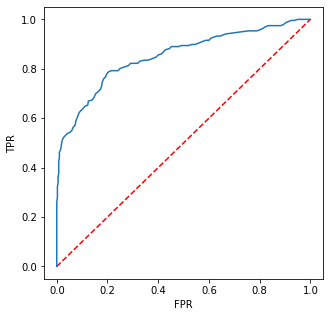

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### ML Pipeline 만들기

1. 트레이닝셋에 수행해야하는 feture transformer들 생성

In [29]:
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, MinMaxScaler

# Gender
stringIndexer = StringIndexer(inputCol = "Gender", outputCol = 'GenderIndexed')

# Age
imputer = Imputer(strategy='mean', inputCols=['Age'], outputCols=['AgeImputed'])

# Vectorize
inputCols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeImputed', 'GenderIndexed']
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")

# MinMaxScaler
minmax_scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

stages = [stringIndexer, imputer, assembler, minmax_scaler]

2. transformer 끝에 사용하고자하는 머신러닝 모델 알고리즘(Estimator) 추가  
3. 앞 단계에서 생성한 것들을 파이썬 리스트로 추가

In [31]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol="features_scaled", labelCol="Survived")
lr_stages = stages + [algo]

In [32]:
lr_stages

[StringIndexer_18d9c266a5ce,
 Imputer_14d351b287b8,
 VectorAssembler_d0d14941cc76,
 MinMaxScaler_9082c944f70b,
 LogisticRegression_eb103d302fdd]

4. 이 파이썬 리스트를 인자로 Pipeline 개체 생성

In [33]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = lr_stages)

In [34]:
df = data.select(['Survived', 'Pclass', 'Gender', 'Age', 'SibSp', 'Parch', 'Fare'])
df.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|SibSp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


5. 이 Pipeline 개체를 이용해서 모델 빌딩

In [35]:
train, test = df.randomSplit([0.7, 0.3])

In [36]:
lr_model = pipeline.fit(train)
lr_cv_predictions = lr_model.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8449622494142164

#### ML Tuning  
 : 가장 좋은 모델을 만드는 하이퍼 파라미터를 찾자


1. 테스트하고 싶은 머신러닝 알고리즘 개체 생성 (혹은 ML Pipeline)

In [37]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')

2. ParamGrid를 만들어 테스트하고 싶은 하이퍼 파라미터 지정

In [38]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(algo.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)


3. CrossValidator 혹은 TrainValidationSplit 생성
4. fit 함수 호출해서 최선의 모델 선택

In [39]:
# Run cross validations.
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8441161155948985

In [40]:
lr_cv_predictions.select("prediction", "survived").show()

+----------+--------+
|prediction|survived|
+----------+--------+
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
+----------+--------+
only showing top 20 rows



In [41]:
import pandas as pd

params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]
pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

,areaUnderROC,maxIter
0,0.834212,1
1,0.849967,5
2,0.851040,10


GBT Classifier  
BinaryClassification이 아닌 GBT Classifier로 해보자

In [42]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features_scaled", labelCol="Survived")
gbt_stages = stages + [gbt]

In [43]:
gbt_stages

[StringIndexer_18d9c266a5ce,
 Imputer_14d351b287b8,
 VectorAssembler_d0d14941cc76,
 MinMaxScaler_9082c944f70b,
 GBTClassifier_df5c35f327fb]

In [44]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = gbt_stages)

In [45]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

In [46]:
# Run cross validations.
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8506899244988285